# Data Challenge 9 — Feature Engineering & Feature Selection

**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Engineer better predictors (one-hot/dummies, interactions, polynomials), avoid unnecessary complexity, and compare a **Base** vs **Engineered** model on the **same train–test split** using **MAE/RMSE**. Interpret coefficients in units and explain business value.



> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

**Docs (quick links):**
- One-hot encoding (pandas): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  
- OneHotEncoder (sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
- Train/Test Split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- MAE / MSE / RMSE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html  
- OLS (statsmodels): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (coef/p/CIs/resid): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

### Pseudocode Plan (Feature Engineering + Selection)
1) **Load CSV** → preview columns/shape.  
2) **Pick Y and initial Xs (2–3 numeric)** → keep it simple and decision-time-available.  
3) **Engineer features:**
   - **One-hot** a categorical with a dropped baseline (e.g., `payment_type` or `weekday/weekend`).  
   - **Interaction**: choose a hypothesis-driven pair (e.g., `trip_distance × is_weekend`).  
   - **Polynomial**: add one squared term for a plausible curve (e.g., `trip_distance²`).  
4) **Build Base vs Engineered design matrices** (add intercept).  
5) **Single train–test split** (80/20, fixed `random_state`) shared by both models.  
6) **Fit on TRAIN**, **predict on TEST** for both models; compute **MAE/RMSE** (units of Y).  
7) **Interpretation**: write unit-based coefficient sentences; note baseline category for dummies.  
8) **Light selection**: if Engineered model doesn’t beat Base on TEST (or adds complexity w/o value), prefer Base.  
9) **Diagnostics (quick)**: residuals vs fitted (train); note any cones (heteroskedasticity).  
10) **Stakeholder one-liner**: which model, why (TEST metrics in units), and what the added features *mean*.
markdown


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
df = pd .read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_50226/1421944564.py:1: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd .read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [3]:
# y being fare_amount and x being tolls_amount, tip_amount
# coerce errors to NaN and then drop those rows
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')
df['tolls_amount'] = pd.to_numeric(df['tolls_amount'], errors='coerce')
df['tip_amount'] = pd.to_numeric(df['tip_amount'], errors='coerce')
df = df.dropna(subset=['fare_amount', 'tolls_amount', 'tip_amount']) 

In [4]:
# clean the data
df = df[(df['fare_amount'] > 0) & 
        (df['tolls_amount'] >= 0) & 
        (df['tip_amount'] >= 0)]

In [5]:
df[['fare_amount', 'tolls_amount', 'tip_amount']].describe()

,fare_amount,tolls_amount,tip_amount
count,"3,268,025.0000","3,268,025.0000","3,268,025.0000"
mean,20.1555,0.5872,3.5570
std,18.1667,2.2227,4.1220
min,0.0100,0.0000,0.0000
25%,9.3000,0.0000,0.6300
50%,14.2000,0.0000,2.8500
75%,23.3000,0.0000,4.5500
max,945.9000,161.3800,380.0000


### Step 3 —  Engineer New Features (One-hot, Interaction, Polynomial)

Pick **one** categorical to one-hot (drop baseline). Options that usually exist:

- `payment_type` (codes): treat as categorical strings for clarity, then one-hot with drop_first=True, or  
- derive **weekday/weekend** from `tpep_pickup_datetime` if present.

Then add **one interaction** and **one squared term** guided by a business hypothesis.

### One-hot 
- I've encoded datetime to make a feature to see seperate dates into weekends and weekdays. This way I can see if fares amount and toll amounts vary across different days of the week to have a deeper understanding of variation changes across this dataset.

In [6]:
df['tpep_pickup_datetime'].head(5)

0    12/01/2023 04:11:39 PM
1    12/01/2023 04:11:39 PM
3    12/01/2023 04:11:39 PM
4    12/01/2023 04:11:39 PM
6    12/01/2023 04:11:40 PM
Name: tpep_pickup_datetime, dtype: object

In [14]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
#  weekend flag (1 = weekend, 0 = weekday)
df['is_weekend'] = df['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

In [8]:
df['tpep_pickup_datetime'].head(5)

0   2023-12-01 16:11:39
1   2023-12-01 16:11:39
3   2023-12-01 16:11:39
4   2023-12-01 16:11:39
6   2023-12-01 16:11:40
Name: tpep_pickup_datetime, dtype: datetime64[ns]

In [9]:
df = pd.get_dummies(df, columns=['is_weekend'], prefix='daytype', drop_first=False)

## Interaction
- People tip slightly less on weekends on average (by around 27 cents)

In [15]:
# **Interaction**: choose a hypothesis-driven pair (e.g., `tip_amount × daytype_1`).  
# do poeple tip more on weekends?  create interaction term and add to model
df['tip_weekend_interaction'] = df['tip_amount'] * df['daytype_1']

In [17]:
df.groupby('is_weekend')['tip_amount'].mean()

is_weekend
0   3.6433
1   3.3656
Name: tip_amount, dtype: float64

## **Polynomial**: add one squared term for a plausible curve 
- Im going to take one variable and add its squared version to help my model capture a possible curve instead of a straight line
- we do this because sometimes the relationship between variables and your target isn’t a straight line, rather it’s curved.
    - For example: imagine the relationship between how far someone rides and how much they tip.
    - short rides -> maybe small tips
    - medium rides -> bigger tips
    - super long rides -> maybe not that much more tip
        - so instead of a straight line, it kinda curves. your model can’t understand that curve unless you give it a “squared” version of the variable.

- by adding tip_amount_squared, the model test:
    - does fare amount rise in a curved way as tip_amount changes? it checks if the change in fare per unit tip stays the same (linear) or speeds up/slows down (curved).

In [18]:
df['tip_amount_squared'] = df['tip_amount'] ** 2
df[['tip_amount', 'tip_amount_squared']].head()

,tip_amount,tip_amount_squared
0,3.0000,9.0000
1,0.0000,0.0000
3,0.0000,0.0000
4,3.0000,9.0000
6,0.0000,0.0000


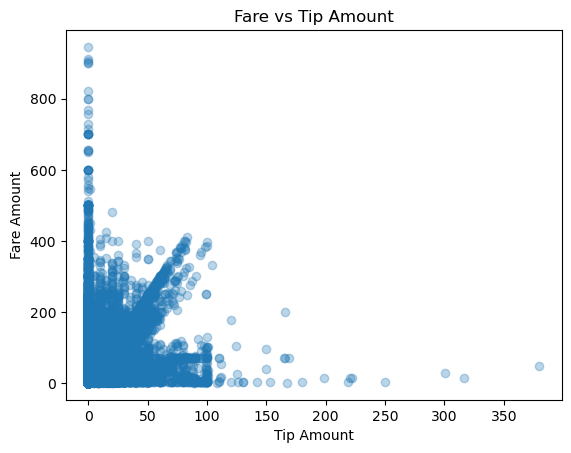

In [19]:
plt.scatter(df['tip_amount'], df['fare_amount'], alpha=0.3)
plt.xlabel('Tip Amount')
plt.ylabel('Fare Amount')
plt.title('Fare vs Tip Amount')
plt.show()


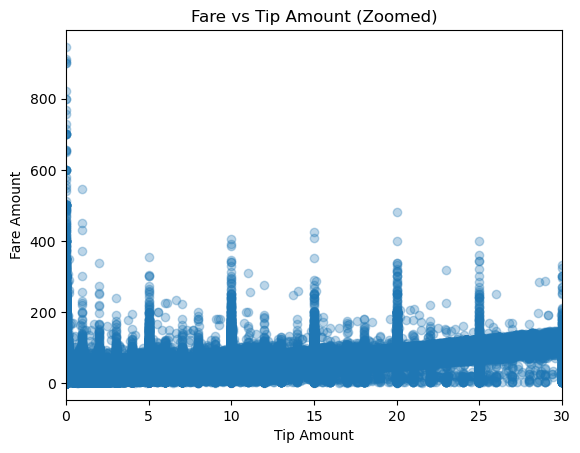

In [20]:
plt.scatter(df['tip_amount'], df['fare_amount'], alpha=0.3)
plt.xlim(0, 30)
plt.xlabel('Tip Amount')
plt.ylabel('Fare Amount')
plt.title('Fare vs Tip Amount (Zoomed)')
plt.show()


In [21]:
import statsmodels.api as sm

X = df[['tip_amount', 'tip_amount_squared']]
y = df['fare_amount']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                 8.078e+05
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:05:26   Log-Likelihood:            -1.3457e+07
No. Observations:             3268025   AIC:                         2.691e+07
Df Residuals:                 3268022   BIC:                         2.691e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.8334      0

- Note: The tip_amount_squared (0.0059) - this small negative number means the relationship bends downward, the higher the tip, the smaller the added increase in fare
    - for small tips, every extra dollar makes a noticeable difference in fare,but for really big tips, that difference becomes smaller and smaller.


#### Insight:


The model predicts fare amount based on tip amount and tip amount squared. It explains about 33% of the variation in fares, which means tip amount is somewhat related to fare, but other factors still play a big role.

The results show that as tip amount increases, the fare also increases, for every extra dollar in tip, the fare goes up by about $2.67 on average. However, the negative squared term means this relationship isn’t perfectly straight, it slows down slightly for higher tips. In other words, at smaller tip amounts, fare rises quickly, but as tips get larger, the increase in fare becomes more gradual.

Overall, the relationship between fare and tip is mostly linear with a small curve, showing that fares grow with tips but at a slower rate as tips get higher.

### Step 4 — Build **Base** and **Engineered** Design Matrices

- **Base** = intercept + base predictors (Xs you assigned in Step 2) 
- **Engineered** = intercept + base predictors + engineered columns (dummies + interaction + polynomial)


In [22]:
X_base = sm.add_constant(df[['tip_amount']])
y = df['fare_amount']


In [ ]:
X_engineered = sm.add_constant(df[['tip_amount', 'is_weekend', 'tip_weekend_interaction', 'tip_amount_squared']])


### Step 5 — Single Train–Test Split (Shared by Both Models)

Use one split so Base and Engineered are comparable.

In [12]:
None

### Step 6 — Fit on TRAIN, Predict on TEST, Compute **MAE/RMSE** (units of Y)

In [ ]:
None

### Step 7 — Interpret Key Coefficients (Plain Language)

Write **unit-based** interpretations for 2–3 impactful coefficients **in the Engineered model**, noting:
- The **baseline** category for dummies (the dropped category).
- **Interaction** meaning (change in slope under the condition).
- **Polynomial** meaning (curve: does effect rise then taper?).


*(Use this template; edit to your variables/units):*

- **Dummy (pay_…):** Compared to baseline **[dropped category]**, the expected **Y** is **β** higher/lower, holding other features constant.  
- **Interaction (dist×weekend):** On weekends, each additional **mile** changes **Y** by **β_interaction** *more/less* than on weekdays, holding other features constant.  
- **Polynomial (distance²):** The marginal effect of distance changes with distance; the negative/positive β on distance² indicates **diminishing/increasing** returns.

### Step 8 —  Quick Diagnostics (Train Residuals) — Engineered Model
- **Residuals vs Fitted:** random cloud ≈ good; cone/funnel suggests non-constant variance.  
- **Q–Q plot:** points roughly along diagonal (normality for inference).  
- **Durbin–Watson:** printed in `eng_model.summary()` (~2 suggests independence).

In [ ]:
None

## We Share — Reflection & Wrap‑Up

**Notes on Feature Selection**
- If **Engineered** doesn’t beat **Base** on TEST (or gains are tiny), prefer **Base** for simplicity.  
- If two engineered features are redundant (e.g., highly correlated dummies), consider dropping one.  
- Keep features that improve TEST error **and** you can explain to a stakeholder.


Write **2 short paragraphs** and be specific:


1) **Which model would you deploy today—Base or Engineered—and why?**  
Use **TEST MAE/RMSE in units**, your coefficient interpretations (baseline/interaction/polynomial), and any residual observations.

2) **What engineered feature was most useful (or not)?**  
Explain the **business logic** behind it and whether it earned its place on the TEST set. If not, what would you try next (different interaction, different categorical, or simplifying features)?